In [1]:

import pandas as pd
import seaborn as sns

from iFEMG_feature import *

In [34]:
# 读取数据，包含三个肌肉信号通道的特征值
data_df = pd.read_csv(r"E:\Data\积水潭患者数据集\w5s1\affected\w5s1_affected_tricps_br.csv", index_col=0, header=[0,1])
data_df.head

<bound method NDFrame.head of       agonist_ch1                                                     \
     subject_name height(cm) weight(kg) gender age    sensor_channel   
0   w5s1_affected        177         71      1  29  tricps_br_medial   
1   w5s1_affected        177         71      1  29  tricps_br_medial   
2   w5s1_affected        177         71      1  29  tricps_br_medial   
3   w5s1_affected        177         71      1  29  tricps_br_medial   
4   w5s1_affected        177         71      1  29  tricps_br_medial   
5   w5s1_affected        177         71      1  29  tricps_br_medial   
6   w5s1_affected        177         71      1  29  tricps_br_medial   
7   w5s1_affected        177         71      1  29  tricps_br_medial   
8   w5s1_affected        177         71      1  29  tricps_br_medial   
9   w5s1_affected        177         71      1  29  tricps_br_medial   
10  w5s1_affected        177         71      1  29  tricps_br_medial   
11  w5s1_affected        177      

In [39]:
df2show = data_df['agonist_ch2']
df2show.head

<bound method NDFrame.head of      subject_name  height(cm)  weight(kg)  gender  age     sensor_channel  \
0   w5s1_affected         177          71       1   29  tricps_br_lateral   
1   w5s1_affected         177          71       1   29  tricps_br_lateral   
2   w5s1_affected         177          71       1   29  tricps_br_lateral   
3   w5s1_affected         177          71       1   29  tricps_br_lateral   
4   w5s1_affected         177          71       1   29  tricps_br_lateral   
5   w5s1_affected         177          71       1   29  tricps_br_lateral   
6   w5s1_affected         177          71       1   29  tricps_br_lateral   
7   w5s1_affected         177          71       1   29  tricps_br_lateral   
8   w5s1_affected         177          71       1   29  tricps_br_lateral   
9   w5s1_affected         177          71       1   29  tricps_br_lateral   
10  w5s1_affected         177          71       1   29  tricps_br_lateral   
11  w5s1_affected         177          71     

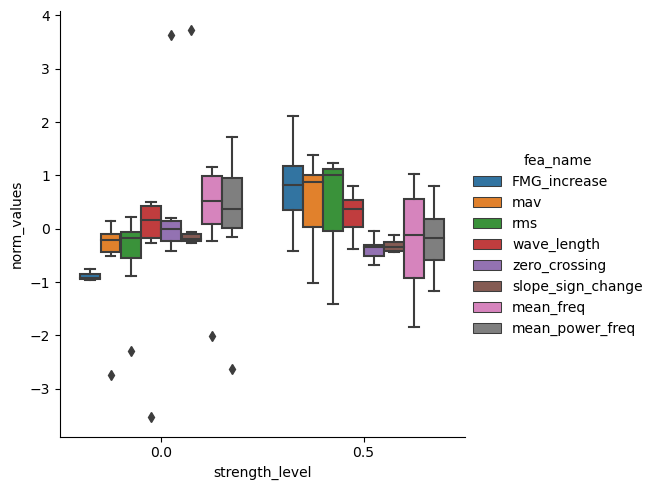

In [40]:
"""
特征可视化
归一化特征值大小----肌力重量
"""
# 需要显示和归一化的特征名称
col_name = ['FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq']
# 调用归一化函数对dataframe进行归一化
sb_fea_norm_df = z_score_norm(df2show, col_name)

# show figure
show_df = pd.DataFrame(columns = ('subject', 'strength_level', 'norm_values', 'fea_name'))

for index, row in sb_fea_norm_df.iterrows():    # go through each row
    for i in col_name:
        show_df = pd.concat([show_df, pd.DataFrame({'subject': [row['subject_name']],
                                                    'strength_level': [row['label(kg)']],
                                                    'norm_values': [row[i]],
                                                    'fea_name': [i]})], axis = 0, ignore_index=True)
# kind = point(两点连线带errbar)/violin(小提琴图)/box(箱线图)
sns.catplot(x = "strength_level",
            y = "norm_values",
            hue = "fea_name",
            data = show_df,
            kind = 'box')

In [11]:
"""
读取df数据，计算其中label为特定值的所有数据的平均值和标准差
"""
# FMG
data_df1 = pd.read_csv(r"E:\Data\20230424-单人双次iFEMG肌力等级测试\normed_fea_tricps_br_absnew.csv", index_col = 0, header = [0, 1])
data_df2 = pd.read_csv(r"E:\Data\20230310-iFEMG肌力测试\normed_fea_tricps_br_absnew.csv", index_col = 0, header = [0, 1])

df = pd.concat([data_df1, data_df2], axis = 0, ignore_index = True)

In [14]:
# 计算平均值
mean_value = df[df[('bicps_br', 'label(kg)')] == 1].mean(numeric_only=True)

# 计算标准差
std_value = df[df[('bicps_br', 'label(kg)')] == 1].std(numeric_only=True)

mean_value

print(f"mean: {mean_value[('bicps_br', 'FMG')]}, std: {std_value[('bicps_br', 'FMG')]}")
print(f"mean: {mean_value[('tricps_br_medial', 'FMG')]}, std: {std_value[('tricps_br_medial', 'FMG')]}")
print(f"mean: {mean_value[('tricps_br_lateral', 'FMG')]}, std: {std_value[('tricps_br_lateral', 'FMG')]}")

mean: 0.6476083272130767, std: 0.28444663818263644
mean: 0.7410429060865593, std: 0.24592327352635057
mean: 0.7475733496023872, std: 0.23754865368014536


In [9]:
df = pd.read_csv(r"E:\Data\iFEMG相关spss\超声数据特征和spss\tricps_stretch_US_norm.csv", index_col = 0, header = 0)

In [10]:
list(df.columns)

['subject',
 'weight',
 'bicps_br_R',
 'bicps_br_thickness',
 'tricps_med_R',
 'tricps_med_thickness',
 'tricps_lat_R',
 'tricps_lat_thickness']

In [14]:
# 计算平均值
mean_value = df[df['weight'] == 1].mean(numeric_only=True)

# 计算标准差
std_value = df[df['weight'] == 1].std(numeric_only=True)

mean_value

print(f"mean: {mean_value['bicps_br_R']}, std: {std_value['bicps_br_R']}")
print(f"mean: {mean_value['bicps_br_thickness']}, std: {std_value['bicps_br_thickness']}")
print(f"mean: {mean_value['tricps_med_R']}, std: {std_value['tricps_med_R']}")
print(f"mean: {mean_value['tricps_med_thickness']}, std: {std_value['tricps_med_thickness']}")
print(f"mean: {mean_value['tricps_lat_R']}, std: {std_value['tricps_lat_R']}")
print(f"mean: {mean_value['tricps_lat_thickness']}, std: {std_value['tricps_lat_thickness']}")

mean: 0.40253796368683326, std: 0.46966299337777057
mean: 0.8409993846506797, std: 0.26199102966301774
mean: 0.05, std: 0.22360679774997888
mean: 0.9343846221518429, std: 0.23072294320851083
mean: 0.05, std: 0.22360679774997888
mean: 0.8936649291748135, std: 0.27943951916082066
